# 學習日期: 2022/5/9開始
## 目標: 透過LSTM模型，預測COVID-19確診人數
- **參考資料1:** https://jishuin.proginn.com/p/763bfbd700c2
- **參考資料2:** https://github.com/CSSEGISandData/COVID-19
- **待研究資料1:** https://blog.csdn.net/helldoger/article/details/107132546

## 0_修改程式 (傳送門)
- [數據分析](#1_數據分析)


- [數據預處理](#2_數據預處理)


- [main-LSTM模型](#3_建立模型-LSTM)


- [main-訓練model](#4.1_訓練模型)


- [main-調超參數](#4.2_訓練模型-設定超參數)


- [預測未來幾天病例](#5.1_最佳模型->預測未來幾天病例)

## 1_數據分析

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.metrics import r2_score  # R_Score

In [2]:
#df = pd.read_csv('2020-2021_time_series_covid19_confirmed_global.csv')  # 將csv載入到DataFrame中; usecols=指定載入的行名
df = pd.read_csv('2020-2021_time_series_covid19_confirmed_global.csv')  # 將csv載入到DataFrame中; usecols=指定載入的行名
#df = pd.read_csv('2020-2021_time_series_covid19_confirmed_global.csv', usecols = ["Lat","Long"])
print(df.head())

  Province/State Country/Region       Lat       Long  2020-1-22  2020-1-23  \
0            NaN    Afghanistan  33.93911  67.709953          0          0   
1            NaN        Albania  41.15330  20.168300          0          0   
2            NaN        Algeria  28.03390   1.659600          0          0   
3            NaN        Andorra  42.50630   1.521800          0          0   
4            NaN         Angola -11.20270  17.873900          0          0   

   2020-1-24  2020-1-25  2020-1-26  2020-1-27  ...  2021-12-22  2021-12-23  \
0          0          0          0          0  ...      157841      157878   
1          0          0          0          0  ...      206616      206935   
2          0          0          0          0  ...      215430      215723   
3          0          0          0          0  ...       21372       21571   
4          0          0          0          0  ...       67199       68362   

   2021-12-24  2021-12-25  2021-12-26  2021-12-27  2021-12-28 

In [3]:
df = df.iloc[:,4:]  # 切掉不要的行(column_index)
print(df.head())  # 內容值=0,157841... ;  column_index=2020-1-22... ;  row_index=0,1,2,3

   2020-1-22  2020-1-23  2020-1-24  2020-1-25  2020-1-26  2020-1-27  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   2020-1-28  2020-1-29  2020-1-30  2020-1-31  ...  2021-12-22  2021-12-23  \
0          0          0          0          0  ...      157841      157878   
1          0          0          0          0  ...      206616      206935   
2          0          0          0          0  ...      215430      215723   
3          0          0          0          0  ...       21372       21571   
4          0          0          0          0  ...       67199       68362   

   2021-12-24  2021-12-25  2021-12-26  2021-12-27  2021-12-28  2021-12-29  \
0      157887      157895  

In [4]:
isnull = df.isnull().sum().sum()  #檢查缺失值
print(isnull)

0


In [5]:
daily_cases = df.sum(axis=0)  # 0:每一列的內容值互相相加 (列1+...+列n =列sum_下面);  1:每一行的內容值相加 (=行sum_右邊)
#print(daily_cases.values)
print("數據=\n",daily_cases.head())
print("日期=\n",daily_cases.index)

daily_cases.index = pd.to_datetime(daily_cases.index)  # column index(時間)的智慧轉換

print("日期(智慧轉換)=",daily_cases.index)

數據=
 2020-1-22     557
2020-1-23     657
2020-1-24     944
2020-1-25    1437
2020-1-26    2120
dtype: int64
日期=
 Index(['2020-1-22', '2020-1-23', '2020-1-24', '2020-1-25', '2020-1-26',
       '2020-1-27', '2020-1-28', '2020-1-29', '2020-1-30', '2020-1-31',
       ...
       '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
       '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31'],
      dtype='object', length=710)
日期(智慧轉換)= DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=710, freq=None)


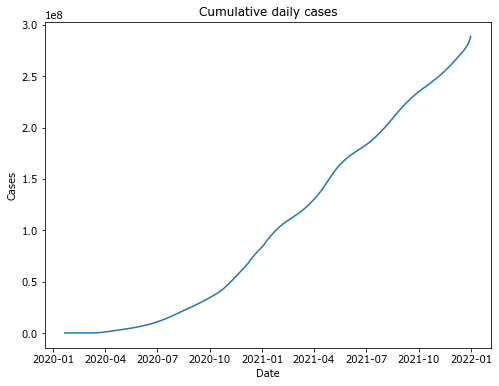

In [6]:
x = daily_cases.index  # 取column index(2020-01)
y = daily_cases.values  # 取DataFrame的內容值
plt.figure(figsize=(8,6))
plt.title('Cumulative daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(x, y)
plt.show()

In [7]:
print("原本累加:")
print(daily_cases.head())

print("\n轉成每日數量:")
temp = daily_cases.diff()  #預設是計算每一列做相減
print(temp.head())

print("\n填充NaN值後:")
daily_cases = temp.fillna(value=daily_cases[0])
print(daily_cases.head())

print("\n轉int後:")
daily_cases = daily_cases.astype(np.int64)  # 轉成int64
print(daily_cases.head())

print("\nShape: ",daily_cases.shape)

原本累加:
2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
dtype: int64

轉成每日數量:
2020-01-22      NaN
2020-01-23    100.0
2020-01-24    287.0
2020-01-25    493.0
2020-01-26    683.0
dtype: float64

填充NaN值後:
2020-01-22    557.0
2020-01-23    100.0
2020-01-24    287.0
2020-01-25    493.0
2020-01-26    683.0
dtype: float64

轉int後:
2020-01-22    557
2020-01-23    100
2020-01-24    287
2020-01-25    493
2020-01-26    683
dtype: int64

Shape:  (710,)


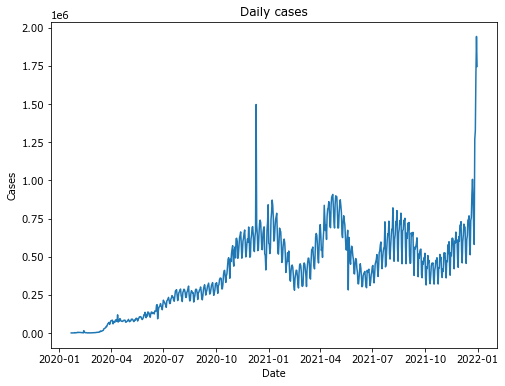

In [8]:
x = daily_cases.index  # 取column index(2020-01)
y = daily_cases.values  # 取DataFrame的內容值

plt.figure(figsize=(8,6))
plt.title('Daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(x, y)
plt.show()

## 2_數據預處理

In [9]:
print("有", daily_cases.size,"天的數據")
val_data_size = 243  # 設定切多少天當驗證集
train_data = daily_cases[:-val_data_size]  # 取前面
val_data = daily_cases[train_data.size:]  # 取後面
print("\n訓練集",train_data.size,"天\n預測集",val_data.size,"天")

print("\ntrain_data=\n",train_data)
print("\nval_data=\n",val_data)

有 710 天的數據

訓練集 467 天
預測集 243 天

train_data=
 2020-01-22       557
2020-01-23       100
2020-01-24       287
2020-01-25       493
2020-01-26       683
               ...  
2021-04-28    898624
2021-04-29    895026
2021-04-30    891776
2021-05-01    794957
2021-05-02    687177
Length: 467, dtype: int64

val_data=
 2021-05-03     689172
2021-05-04     785654
2021-05-05     842368
2021-05-06     872575
2021-05-07     834989
               ...   
2021-12-27    1268219
2021-12-28    1326584
2021-12-29    1696421
2021-12-30    1942505
2021-12-31    1745974
Length: 243, dtype: int64


In [10]:
# 提高模型的"訓練速度"、"性能" ---> 按比例縮放數據(0~1)
# 使用scikit-learn的MinMaxScaler(最小最大值標準化)
# Reference: https://cloud.tencent.com/developer/article/1770568

# 注意: 是用train data進行擬合fit(模型)，然後對 train & val 都用此模型進行 trainsform (因fit兩次會造成在不同標準下做trainsform)
## train: fit + transform
## val: transform

# DataFrame(467行) -> values內容值(467列,1行)
train_data = np.expand_dims(train_data, axis=1)  # (467列，1列存放1個數值)
val_data = np.expand_dims(val_data, axis=1)    # axis=1: (467) -> (467,1)

print("轉換前:")
print(train_data[:5])

# 1. fit: (做完就包含數據分布情況，但未歸一化)
scaler_type = MinMaxScaler()  # 選擇計算類型
scaler = scaler_type.fit(train_data)  # 自動算出"最大值" "最小值"
#print(scaler.data_max_)  # 測試: 最大值


# 2. transform: (train)
print("train_data shape=", train_data.shape)
train_data = scaler.transform(train_data)  # 歸一化 (意思是，將數據壓縮到0-1之間，對應MinMax規範方法)
    # 歸一化可以消除量綱對最終結果的影響，使不同變數具有可比性。
    # 例子: 比如兩個人體重差10KG，身高差0.02M，在衡量兩個人的差別時體重的差距會把身高的差距完全掩蓋，歸一化之後就不會有這樣的問題。
    
print("\n轉換後:")
print(train_data[:5])

# 2. transform: (val)
# val_data = (243, 1)
val_data = scaler.transform(val_data)
# val_data = <class 'numpy.ndarray'>

轉換前:
[[557]
 [100]
 [287]
 [493]
 [683]]
train_data shape= (467, 1)

轉換後:
[[0.00030536]
 [0.        ]
 [0.00012495]
 [0.00026259]
 [0.00038955]]


In [11]:
# 七天一個循環 (x:前7天  y_label:第8天)

print("train data=",len(train_data),"\n")
data = train_data

def create_sequence(data, seq_length):
    x_list = []
    y_list = []
    for i in range(len(data)-seq_length):  # !!重要: 不能-1，發現會導致少算一次，前面版本都錯了QQ
        x = data[i:i+seq_length]  # 0~6
        y = data[i+seq_length]  # 7
        x_list.append(x)
        y_list.append(y)
        
    return np.array(x_list), np.array(y_list)

seq_length = 7  # time_step

train_x, train_y = create_sequence(train_data, seq_length)
val_x, val_y = create_sequence(val_data, seq_length)

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y).float()
val_x = torch.from_numpy(val_x).float()
val_y = torch.from_numpy(val_y).float()

print("train x=",train_x.shape)
print("train y=",train_y.shape,"\n")
print(train_x[0],"\n")  # !!!原本數據類型: float64 -> 餵入model數據 要轉成 float32 才能run

train_x = train_x.float()  # float64 -> float32
print(train_x[0])

train data= 467 

train x= torch.Size([460, 7, 1])
train y= torch.Size([460, 1]) 

tensor([[0.0003],
        [0.0000],
        [0.0001],
        [0.0003],
        [0.0004],
        [0.0005],
        [0.0017]], dtype=torch.float64) 

tensor([[0.0003],
        [0.0000],
        [0.0001],
        [0.0003],
        [0.0004],
        [0.0005],
        [0.0017]])


## 3_建立模型-LSTM

In [12]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, seq_length):  # 這裡加入要傳入的參數，使用時記得要加self.X = X
        super(LSTM, self).__init__()
        
        # 導入參數
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.seq_length = seq_length
        
        # model設計
        self.rnn = nn.LSTM(
            input_size = input_size,  # input shape
            hidden_size = hidden_size,  # output shape
            num_layers = num_layers,
            dropout = dropout
            #batch_first = True  # 只是做 原(459,7,1) -> (7,459,1)，這次沒有設batch_size，固batch_size=459 (全部data)
                                 # (batch_size, time_step, input_size) batch已經在最前面，不需再batch_first
        )
        self.out = nn.Linear(hidden_size, 1)  # (in_features, out_features)->(512, 1)
        
    def reset_hidden_state(self):  # 清空inputs的 h_0, c_0 (state)->讓每個epoch開始訓練 都是空的state
        self.h_0 = torch.zeros(self.num_layers, self.seq_length, self.hidden_size)  # 透過self，抓取外界傳入的參數(初始化需先導入)
        self.c_0 = torch.zeros(self.num_layers, self.seq_length, self.hidden_size)
        
    def forward(self, x):
        """
        x: (batch_size, time_step(seq_length), input_size)
        h_n = 最後一個time_step的 "hidden state" (輸出)   h_n = lstm_out[:,-1,:]
        c_n = 最後一個time_step的 "cell state" (cell當前狀態)
        """
        
        # 若有使用gpu，hidden tensor也需移到gpu
        if use_GPU == True and torch.cuda.is_available() == True:
            self.h_0, self.c_0 = self.h_0.cuda(), self.c_0.cuda()
            
        #---x: (459, 7, 1)    
        lstm_out, (self.h_n, self.c_n) = self.rnn(x, (self.h_0, self.c_0))  # 1 -> 512 
        #---lstm_out: (459, 7, 512)
        
        # 查看hidden_state (tuple → tensor)
        #hidden_state = torch.stack(list((self.h_0,self.c_0)), dim=0)  # h_n, c_n = hidden_state = (2, num_layers, 7, 512)
        #print(hidden_state.shape)  # hidden_state: ( (h,c), num_layers, time_step(seq_length), hidden_size)
        
        #---lstm_out: (459, 7, 512)
        last_time_step = lstm_out.view(seq_length, len(x), hidden_size)  # 改變數據shape (取出 7的最後一個 時間步(time_step) 的輸出)
        #---last_time_step: (7, 459, 512)
        last_time_step = last_time_step[-1]  # 取0~6的最後一列
        #---last_time_step: (459, 512)
        output = self.out(last_time_step)  # (459, 512) -> (459, 1)
        #---output: (459, 1)  # 459列 預測的結果
        return output  # y_predict

[lstm_out、h_n 和 c_n 之間的關係](https://blog.csdn.net/sdnuwjw/article/details/111221937)
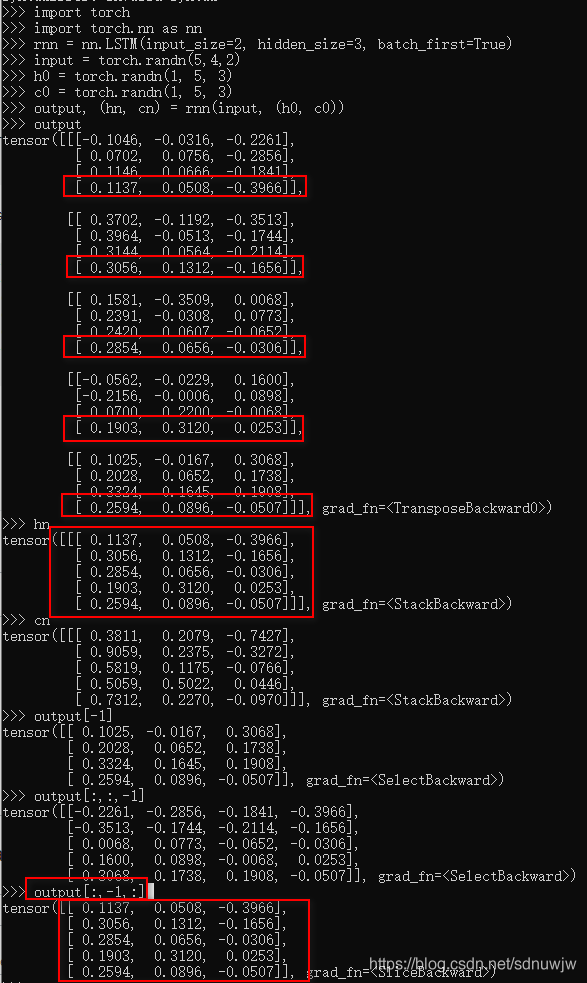

## 4.1_訓練模型
- 回歸模型評估指標 [[總覽1](https://www.cnblogs.com/HuZihu/p/10300760.html)] [[總覽2](https://blog.csdn.net/lch551218/article/details/113573931)]
    - [R squared](https://medium.com/qiubingcheng/%E5%9B%9E%E6%AD%B8%E5%88%86%E6%9E%90-regression-analysis-%E7%9A%84r%E5%B9%B3%E6%96%B9-r-squared-%E8%88%87%E8%AA%BF%E6%95%B4%E5%BE%8Cr%E5%B9%B3%E6%96%B9-adjusted-r-squared-f38ad733bc4e) ([2](https://blog.csdn.net/jpld/article/details/103526882?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_baidulandingword~default-0-103526882-blog-80061191.pc_relevant_default&spm=1001.2101.3001.4242.1&utm_relevant_index=2)) ([3](https://blog.csdn.net/jpld/article/details/103526882?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_baidulandingword~default-0-103526882-blog-80061191.pc_relevant_default&spm=1001.2101.3001.4242.1&utm_relevant_index=2)) ([判斷標準](http://amebse.nchu.edu.tw/new_page_535.htm))

In [13]:
def train_model(model, epoch, lr, train_data, train_label, val_data, val_label, use_GPU, performance_eval):
    # 設定loss模型 + 優化器
    loss_fn = torch.nn.MSELoss(reduction='sum')  # 默認'mean'
    optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    # 動態調整學習率
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode='min', factor=0.1, patience=100, min_lr=0.00001)
    
    # 回歸模型的表現評價指標（Regression Model Performance Evaluation Metric）
    best_epoch = 0
    if performance_eval == 'MAE':  # https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
        evaluation_func = torch.nn.L1Loss(reduction='mean')  # (平均絕對誤差) MAE = sum(|y-x|)的平均
        best_evaluation = 1.0  # 初始最高，越低越好
    elif performance_eval == 'MSE':  # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss
        evaluation_func = torch.nn.MSELoss(reduction='mean')  # (均方誤差) MSE = sum((y-x)^2)的平均
        best_evaluation = 1.0  # 初始最高，越低越好
    elif performance_eval == 'R_square':  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
        evaluation_func = torch.nn.MSELoss(reduction='sum')
        best_evaluation = -10.0  # 初始最低，越高越好
    elif performance_eval == 'MAPE':
        evaluation_func = None
        best_evaluation = 100.0  # 初始最高，越低越好  # https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
        

    # 保存loss歷史數據，plt看圖用
    train_loss_list = np.zeros(epoch)
    val_loss_list = np.zeros(epoch)

    # 數據轉移到GPU運算
    if use_GPU == True and torch.cuda.is_available() == True:
        model.cuda()  # model參數計算 -> 移到GPU
        train_data, train_label = train_data.cuda(), train_label.cuda()
        if val_data is not None:
            val_data, val_label = val_data.cuda(), val_label.cuda()
        

    
    # 開始訓練epoch
    for i in range(epoch):
        model.train()  # 開啟訓練模式 (因驗證時會改成eval模式)
        model.reset_hidden_state()  # 無狀態LSTM
        
        #---train_data: (459, 7, 1)
        y_pred = model(train_data)
        #---y_pred: (459, 1)
                
        # 比較data差異
        #print(train_label[5])
        #print(y_pred[5])
        
        # 計算loss
        loss = loss_fn(train_label, y_pred)  # (y_predict, y_label)
        
        # 加入測試集-驗證+評估最佳模型
        if val_data is not None:
            with torch.no_grad():  # 被該語句包裹起來的程式碼，就不會被追蹤gradient
                y_pred_val = model(val_data)
                loss_val = loss_fn(val_label, y_pred_val)
                
                # 使用val_data評估回歸模型表現的指標----------------------------------
                if performance_eval == 'MAE' or performance_eval == 'MSE':
                    evaluation = evaluation_func(val_label, y_pred_val)  # 導入模型評估指標
                    if best_evaluation > evaluation.item():
                        best_evaluation = evaluation.item()  # 最佳模型評估指標
                        best_epoch = i
                        # 保存模型
                        torch.save(model,'best_model.pth')  # 根據評估指標-保存最佳模型
                elif performance_eval == 'R_square':
                    # 手刻R_square:
                    # R_square = 1 - {sum((y-x)^2) / sum((y-y平均)^2)}
                    evaluation = evaluation_func(val_label, y_pred_val)
                    evaluation = evaluation.item() / np.sum( np.square( val_label.cpu().numpy() - np.mean(val_label.cpu().numpy()) ) )
                    evaluation = 1 - evaluation
                    #evaluation = r2_score(val_label.cpu(), y_pred_val.cpu())  # 利用sklearn，快速導入R_square評估指標
                    if best_evaluation < evaluation:
                        best_evaluation = evaluation
                        best_epoch = i
                        # 保存模型
                        torch.save(model,'best_model.pth')
                elif performance_eval == 'MAPE':
                    # 手刻MAPE:
                    evaluation = np.mean(np.abs(val_label.cpu().numpy() - y_pred_val.cpu().numpy()) / np.abs(val_label.cpu().numpy()))*100
                    if best_evaluation > evaluation:
                        best_evaluation = evaluation
                        best_epoch = i
                        # 保存模型
                        torch.save(model,'best_model.pth')
                                   
                if i == (epoch-1):
                    torch.save(model,'last_model.pth')  # 根據最後一回合-保存模型
                #-------------------------------------------------------
                
            val_loss_list[i] = loss_val.item()  # 保存loss_val history
            
            # 每十回合印出那一個回合的loss值(非最佳)，"評估最佳指標"才是每回合的(最佳)
            if (i%20 == 0) or (i == epoch-1):  # 最後一個epoch也印出
                print(f'Epoch {i}  train loss: {loss.item():.4f}  val loss: {loss_val.item():.4f}    最佳評估指標 {performance_eval}= {best_evaluation:.4f}  (best_epoch={best_epoch})')  # :.4f 取小數後四位
            if i == best_epoch:
                print(f'    best_epoch {best_epoch}  val loss: {loss_val.item():.4f}')
        
        elif (i%20 == 0) or (i == epoch-1):  # 沒有val_data時
            print(f'Epoch {i}  train loss: {loss.item()}')  # .item(): tensor->內容值(values)
        
        train_loss_list[i] = loss.item()  # 保存loss history

        # 動態調整學習率
        #lr_scheduler.step(best_evaluation)
        
        # 固定不變
        optim.zero_grad()
        loss.backward()
        optim.step()

    return model.eval(), train_loss_list, val_loss_list  # model.eval() 因後面是測試模式

## 4.2_訓練模型-設定超參數

In [14]:
# 設定參數--------------------------------------------------------------------
epoch = 500
lr = 1e-3
input_size = 1  # 若為圖片，size= W x H，這裡是確診人數，size= 1
hidden_size = 512  # 隱藏層神經元數
num_layers = 2  # LSTM層數
dropout = 0.5
seq_length = 7  # 就是time_step; 若要調值，上面 "2.數據預處理-seq_length" 也要改
use_GPU = True
performance_eval = 'MAPE'  # 模型評估指標: MSE、MAE、R_square、MAPE

# 強迫固定亂數，方便研究用
np.random.seed(1)
torch.manual_seed(1)
# ---------------------------------------------------------------------------

# 讀取model
model = LSTM(input_size, hidden_size, num_layers, dropout, seq_length)  # Model: 跑了__init__初始化的東西

# 查看GPU訊息
if use_GPU == True:
    if torch.cuda.is_available() == True:
        GPU_num = torch.cuda.device_count()
        print(f'GPU總共有 {GPU_num} 個')
        print(f'顯示卡: {torch.cuda.get_device_name(0)}\n')  # 0: 第0張顯示卡
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 如果GPU0正在運行程序，需要指定其他GPU時使用 (需 import os)
    else:
        print(f'我沒有GPU')
        
# 查看餵入的數據shape是否正確
print("查看餵入的數據shape是否正確:")
print("x =",train_x.shape, "  (batch_size, time_step, input_size)\n")


# 開始訓練
model, train_loss_list, val_loss_list = train_model(model, epoch, lr, train_x, train_y, val_x, val_y, use_GPU, performance_eval) 
# Model: 跑了forward的東西
# 這裡的model = .eval()測試模式

GPU總共有 1 個
顯示卡: NVIDIA GeForce RTX 3060 Laptop GPU

查看餵入的數據shape是否正確:
x = torch.Size([460, 7, 1])   (batch_size, time_step, input_size)

Epoch 0  train loss: 31.8032  val loss: 33.0946    最佳評估指標 MAPE= 94.2330  (best_epoch=0)
    best_epoch 0  val loss: 33.0946
    best_epoch 1  val loss: 14.8509
    best_epoch 2  val loss: 4.4645
Epoch 20  train loss: 8.8741  val loss: 7.7416    最佳評估指標 MAPE= 22.1911  (best_epoch=2)
    best_epoch 21  val loss: 4.9308
    best_epoch 36  val loss: 4.8017
Epoch 40  train loss: 9.7383  val loss: 7.3313    最佳評估指標 MAPE= 20.7597  (best_epoch=36)
    best_epoch 58  val loss: 3.2317
Epoch 60  train loss: 5.2644  val loss: 3.5725    最佳評估指標 MAPE= 18.2976  (best_epoch=58)
    best_epoch 75  val loss: 3.0666
Epoch 80  train loss: 3.8910  val loss: 3.0805    最佳評估指標 MAPE= 18.0998  (best_epoch=75)
Epoch 100  train loss: 10.5004  val loss: 5.5603    最佳評估指標 MAPE= 18.0998  (best_epoch=75)
Epoch 120  train loss: 11.3874  val loss: 8.7143    最佳評估指標 MAPE= 18.0998  (best_epo

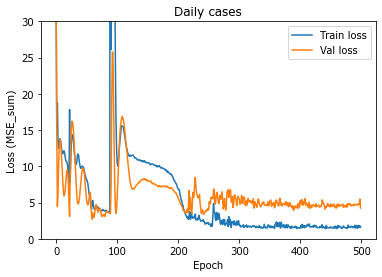

In [15]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Val loss')
plt.title('Daily cases')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE_sum)")
plt.ylim((0, 30))
plt.legend()

## 5.1_最佳模型->預測未來幾天病例
### (利用預測的值來預測未來)

In [16]:
# 加載模型
best_model = torch.load('best_model.pth')

if use_GPU == True and torch.cuda.is_available() == True:
    best_model.cuda()
best_model.eval()  # 固定dropout和批次歸一化

with torch.no_grad():
    val_x = val_x.cuda()  # 轉回gpu
    # val_x = (235, 7, 1)
    val_seq_input = val_x[:1]
    # val_seq_input = (1, 7, 1)
    get_preds = []  # 存放model預測結果"get"
    
    # 把input前7天 + 透過模型預測的第8天 "串接起來" -> {右移一天} -> 此時input中上次預測的變第7天 + model -> 得到預測的第8天
    # -> {迴圈下去} -> 使用預測值作為預測未來幾天的輸入
    for _ in range(len(val_x)):
        # val_seq_input = (1, 7, 1)
        val_seq_pred = best_model(val_seq_input.cuda())
        # val_seq_pred = (1, 1)
        #print(val_seq_pred)
        get = torch.flatten(val_seq_pred).item()  # get = 取出model預測的"內容值"
        get_preds.append(get)  # 預測結果"串接起來"
        new_seq = val_seq_input.cpu().numpy().flatten()  # shape = (7)
        new_seq = np.append(new_seq, [get])  # shape = (8)
        new_seq = new_seq[1:]  # 向右移一天
        #print(new_seq)
        val_seq_input = torch.as_tensor(new_seq).view(1, seq_length, 1).float()  # torch.Size([7]) -> torch.Size([1, 7, 1])
        # val_seq_input = (1, 7, 1)

In [17]:
# 1. 撤銷val數據的normalize轉換比例 -> 逆縮放轉換 -> 得到原始數據"全球確診人數"
# 2. val_y(真實) vs. get_preds(模型預測)

#--------------------val_y(真實)---------------------
# val_y = (235, 1)
temp = np.expand_dims(val_y.flatten().numpy(), axis=0)  # 新增一維度 -> 0=[1, *, *], 1=[*, 1, *]
# temp = (1, 235)
#-----------------------------------
# transform: (len(), 1)
# inverse_transform: (1, len())
#-----------------------------------
# temp = (1, 235)
true_cases = scaler.inverse_transform(temp)  # inverse_transform
# true_cases = (1, 235)
true_cases = true_cases.flatten()
# true_case = (235)

#--------------------get_preds(模型預測)---------------------
# 做一樣的事
pred_cases = scaler.inverse_transform(np.expand_dims(get_preds, axis=0)).flatten()
print(pred_cases.shape)

(236,)


In [18]:
# 測試下來，不用轉shape，也可以 (對應前面"轉換前")
print(train_data[:5])
a = scaler.inverse_transform(train_data).flatten()
b = scaler.inverse_transform(np.expand_dims(train_data.flatten(), axis=0)).flatten()
print(a[:5])
print(b[:5])

[[0.00030536]
 [0.        ]
 [0.00012495]
 [0.00026259]
 [0.00038955]]
[557. 100. 287. 493. 683.]
[557. 100. 287. 493. 683.]


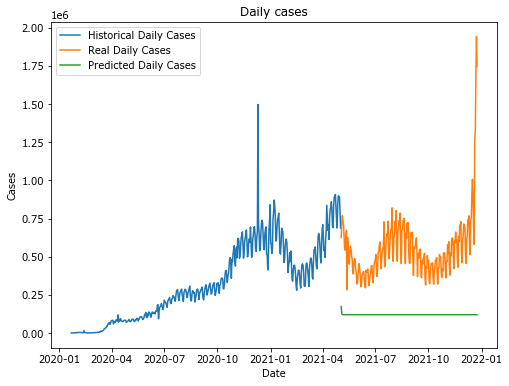

In [19]:
# plt.plot(x, y, label='')  (x=日期, y=全球確診人數) (必須len(x)=len(y)對應)
plt.figure(figsize=(8,6))
plt.plot(daily_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='Historical Daily Cases')  #已知確診人數
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(true_cases)], true_cases, label='Real Daily Cases')  # 預測之label
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(pred_cases)], pred_cases, label='Predicted Daily Cases')  # 預測之Output
plt.title('Daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()

## 5.2_最佳模型->預測未來幾天病例
### (每次預測的結果，去比較與真實的差異)

In [20]:
# 加載模型
best_model = torch.load('best_model.pth')
best_model.eval()  # 固定dropout和批次歸一化

with torch.no_grad():
    # val_seq_input = (235, 7, 1)
    val_seq_pred = best_model(val_x)
    # val_seq_pred = (235, 1)
    print(val_seq_pred.shape)
    pred_cases = scaler.inverse_transform(np.expand_dims(val_seq_pred.cpu().flatten().numpy(), axis=0)).flatten()
    # pred_cases = (235)
    print(pred_cases.shape)

torch.Size([236, 1])
(236,)


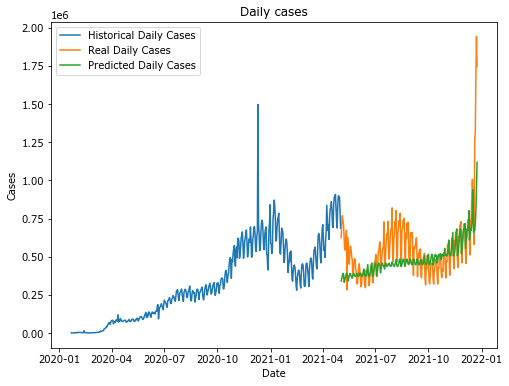

In [21]:
# plt.plot(x, y, label='')  (x=日期, y=全球確診人數) (必須len(x)=len(y)對應)
plt.figure(figsize=(8,6))
plt.plot(daily_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='Historical Daily Cases')  #已知確診人數
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(true_cases)], true_cases, label='Real Daily Cases')  # 預測之label
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(pred_cases)], pred_cases, label='Predicted Daily Cases')  # 預測之Output
plt.title('Daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()

## 5.3_最後epoch模型->預測未來幾天病例
### (最佳模型 vs. 最後epoch模型)

使用的模型評估指標 -> MAPE


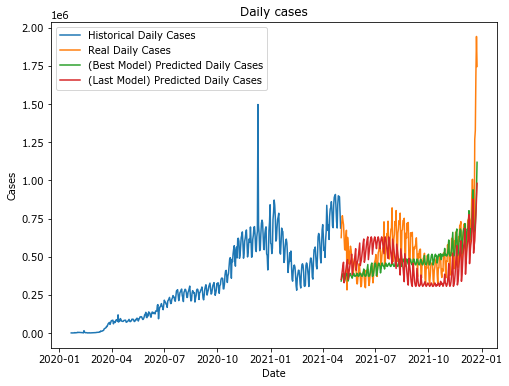

In [22]:
# 加載模型
last_model = torch.load('last_model.pth')
last_model.eval()  # 固定dropout和批次歸一化

with torch.no_grad():
    # val_seq_input = (235, 7, 1)
    val_seq_pred = last_model(val_x)
    # val_seq_pred = (235, 1)
    last_pred_cases = scaler.inverse_transform(np.expand_dims(val_seq_pred.cpu().flatten().numpy(), axis=0)).flatten()
    # last_pred_cases = (235)
    
print(f'使用的模型評估指標 -> {performance_eval}')
# plt.plot(x, y, label='')  (x=日期, y=全球確診人數) (必須len(x)=len(y)對應)
plt.figure(figsize=(8,6))
plt.plot(daily_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='Historical Daily Cases')  #已知確診人數
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(true_cases)], true_cases, label='Real Daily Cases')  # 預測之label
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(pred_cases)], pred_cases, label='(Best Model) Predicted Daily Cases')  # 預測之Output
plt.plot(daily_cases.index[len(train_data): len(train_data)+len(pred_cases)], last_pred_cases, label='(Last Model) Predicted Daily Cases')  # 預測之Output
plt.title('Daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()